In [2]:
from datetime import datetime, timedelta
import requests
from concurrent.futures import ThreadPoolExecutor, as_completed
import duckdb
import textwrap
con = duckdb.connect()
def SQL(q):
    """Run SQL (printed for clarity) and return a DataFrame."""
    return con.execute(q).fetchdf()
print("DuckDB version:", con.sql("SELECT version();").fetchone()[0])
SQL("""
    ATTACH 'ducklake:my_ducklake.ducklake' AS mobility_ducklake;
    USE mobility_ducklake;
    """)

DuckDB version: v1.4.2


,Success


In [3]:
#Count rows in the bronze_raw_mobility_trips table

SQL("""
SELECT COUNT(*) AS row_count
FROM bronze_raw_mobility_trips;    
    """)

,row_count
0,6532064564


In [3]:
#Count rows with 'NA' in the edad column

SQL("""
SELECT COUNT(*) AS na_count
FROM bronze_raw_mobility_trips
WHERE edad = 'NA'   
    """)

,na_count
0,1724645192


In [ ]:
#Count rows with viajes equal to 0

SQL("""
SELECT COUNT(*) AS na_count
FROM bronze_raw_mobility_trips
WHERE viajes = 0.0 OR viajes IS NULL  
    """)

,na_count
0,0


: 

In [3]:
# Keep only relevant columns

SQL("""
CREATE OR REPLACE TABLE bronze_raw_mobility_trips AS
SELECT 
    fecha AS date,
    periodo AS hour_period,
    origen AS origin_zone,
    destino AS destination_zone,
    viajes AS trips,
    ingestion_date
FROM bronze_raw_mobility_trips;
""")

,Count
0,6573331039


In [ ]:
# Create a sample table for January 2023 to speed up test computations

SQL("""
CREATE OR REPLACE TABLE bronze_raw_mobility_trips_sample AS
SELECT *
FROM bronze_raw_mobility_trips
WHERE date >= 20230101 AND date < 20230201
""")

,Count
0,552509346


In [ ]:
# Check for duplicates based on (fecha, periodo, origen, destino) to observe the behavior of viajes
# We don't observe any relationship between duplicates and their trips count

SQL("""
SELECT fecha, periodo, origen, destino, viajes
FROM bronze_raw_mobility_trips_sample
WHERE (fecha, periodo, origen, destino) IN (
    SELECT fecha, periodo, origen, destino
    FROM bronze_raw_mobility_trips_sample
    GROUP BY fecha, periodo, origen, destino
    HAVING COUNT(*) > 1
)
ORDER BY fecha, periodo, origen, destino
LIMIT 50
""")

,fecha,periodo,origen,destino,viajes
0,20230101,00,01001,01001,2.922000
1,20230101,00,01001,01001,5.202000
2,20230101,00,01001,01009_AM,1.000000
3,20230101,00,01001,01009_AM,1.000000
4,20230101,00,01001,01009_AM,2.336398
5,20230101,00,01001,01009_AM,2.354009
6,20230101,00,01001,01009_AM,1.186984
7,20230101,00,01001,01009_AM,1.267995
8,20230101,00,01001,0105901,1.188038
9,20230101,00,01001,0105901,1.000000


In [ ]:
# Create a table with the public holidays in Spain for the year 2023

SQL("""
CREATE OR REPLACE TABLE festivos_espana_2023 AS
SELECT DATE '2023-01-06' AS date, 'Epifanía del Señor (Reyes)' AS festivo UNION ALL
SELECT DATE '2023-04-07', 'Viernes Santo' UNION ALL
SELECT DATE '2023-05-01', 'Fiesta del Trabajo' UNION ALL
SELECT DATE '2023-08-15', 'Asunción de la Virgen' UNION ALL
SELECT DATE '2023-10-12', 'Fiesta Nacional de España' UNION ALL
SELECT DATE '2023-11-01', 'Todos los Santos' UNION ALL
SELECT DATE '2023-12-06', 'Día de la Constitución Española' UNION ALL
SELECT DATE '2023-12-08', 'Inmaculada Concepción' UNION ALL
SELECT DATE '2023-12-25', 'Natividad del Señor (Navidad)';
""")

,Count
0,9


In [ ]:
# Create a new table classifying trips based on the day of the week and whether it's a holiday, weekend, bridge day, or weekday

SQL("""
CREATE OR REPLACE TABLE viajes_clasificados AS
WITH trips_con_fecha AS (
    SELECT 
        *,
        STRPTIME(CAST(date AS VARCHAR), '%Y%m%d')::DATE AS fecha
    FROM bronze_raw_mobility_trips_sample
)
SELECT 
    t.*,
    DAYOFWEEK(t.fecha) AS dow,
    CASE DAYOFWEEK(t.fecha)
        WHEN 2 THEN 'Lunes'
        WHEN 3 THEN 'Martes'
        WHEN 4 THEN 'Miércoles'
        WHEN 5 THEN 'Jueves'
        WHEN 6 THEN 'Viernes'
        WHEN 7 THEN 'Sábado'
        WHEN 1 THEN 'Domingo'
    END AS dia_semana,
    CASE 
        WHEN f.date IS NOT NULL THEN 'festivo'
        WHEN DAYOFWEEK(t.fecha) IN (1, 7) THEN 'finde'
        WHEN DAYOFWEEK(t.fecha) = 6 AND f_jueves.date IS NOT NULL THEN 'puente'
        WHEN DAYOFWEEK(t.fecha) = 2 AND f_martes.date IS NOT NULL THEN 'puente'
        ELSE 'entre_semana'
    END AS tipo_dia
FROM trips_con_fecha t
LEFT JOIN festivos_espana_2023 f ON t.fecha = f.date
LEFT JOIN festivos_espana_2023 f_jueves ON t.fecha - INTERVAL 1 DAY = f_jueves.date
LEFT JOIN festivos_espana_2023 f_martes ON t.fecha + INTERVAL 1 DAY = f_martes.date
""")
print("Tabla viajes_clasificados creada ✓")

Tabla viajes_clasificados creada ✓


In [2]:
SQL("""SELECT * FROM viajes_clasificados LIMIT 10;""")

,date,hour_period,origin_zone,destination_zone,trips,ingestion_date,fecha,dow,dia_semana,tipo_dia
0,20230103,00,01001,01001,2.445,2025-12-10 15:08:44.532925+01:00,2023-01-03,2,Lunes,entre_semana
1,20230103,02,01001,01001,5.617,2025-12-10 15:08:44.532925+01:00,2023-01-03,2,Lunes,entre_semana
2,20230103,04,01001,01001,2.667,2025-12-10 15:08:44.532925+01:00,2023-01-03,2,Lunes,entre_semana
3,20230103,04,01001,01001,2.443,2025-12-10 15:08:44.532925+01:00,2023-01-03,2,Lunes,entre_semana
4,20230103,06,01001,01001,5.538,2025-12-10 15:08:44.532925+01:00,2023-01-03,2,Lunes,entre_semana
5,20230103,06,01001,01001,2.667,2025-12-10 15:08:44.532925+01:00,2023-01-03,2,Lunes,entre_semana
6,20230103,07,01001,01001,3.093,2025-12-10 15:08:44.532925+01:00,2023-01-03,2,Lunes,entre_semana
7,20230103,07,01001,01001,2.445,2025-12-10 15:08:44.532925+01:00,2023-01-03,2,Lunes,entre_semana
8,20230103,08,01001,01001,2.443,2025-12-10 15:08:44.532925+01:00,2023-01-03,2,Lunes,entre_semana
9,20230103,08,01001,01001,2.667,2025-12-10 15:08:44.532925+01:00,2023-01-03,2,Lunes,entre_semana


In [21]:
df_patrones = SQL("""
WITH datos AS (
    SELECT 
        CASE 
            WHEN tipo_dia IN ('finde', 'festivo', 'puente') THEN tipo_dia
            ELSE dia_semana
        END AS categoria,
        CASE 
            WHEN tipo_dia IN ('finde', 'festivo', 'puente') THEN 
                CASE tipo_dia WHEN 'finde' THEN 10 WHEN 'festivo' THEN 11 WHEN 'puente' THEN 12 END
            ELSE dow
        END AS orden,
        hour_period,
        trips
    FROM viajes_clasificados
),
totales AS (
    SELECT categoria, SUM(trips) AS total
    FROM datos
    GROUP BY categoria
),
por_hora AS (
    SELECT categoria, orden, hour_period, SUM(trips) AS total_viajes
    FROM datos
    GROUP BY categoria, orden, hour_period
)
SELECT 
    p.categoria,
    p.orden,
    p.hour_period,
    p.total_viajes,
    ROUND(100.0 * p.total_viajes / t.total, 2) AS pct_del_dia
FROM por_hora p
JOIN totales t ON p.categoria = t.categoria
ORDER BY p.orden, p.hour_period
""")

df_patrones

,categoria,orden,hour_period,total_viajes,pct_del_dia
0,Lunes,2,00,1.285682e+07,1.90
1,Lunes,2,01,7.177108e+06,1.06
2,Lunes,2,02,5.179907e+06,0.77
3,Lunes,2,03,4.366088e+06,0.65
4,Lunes,2,04,4.868482e+06,0.72
...,...,...,...,...,...
187,puente,12,19,6.990940e+06,6.18
188,puente,12,20,6.705748e+06,5.93
189,puente,12,21,5.977270e+06,5.28
190,puente,12,22,4.952132e+06,4.38


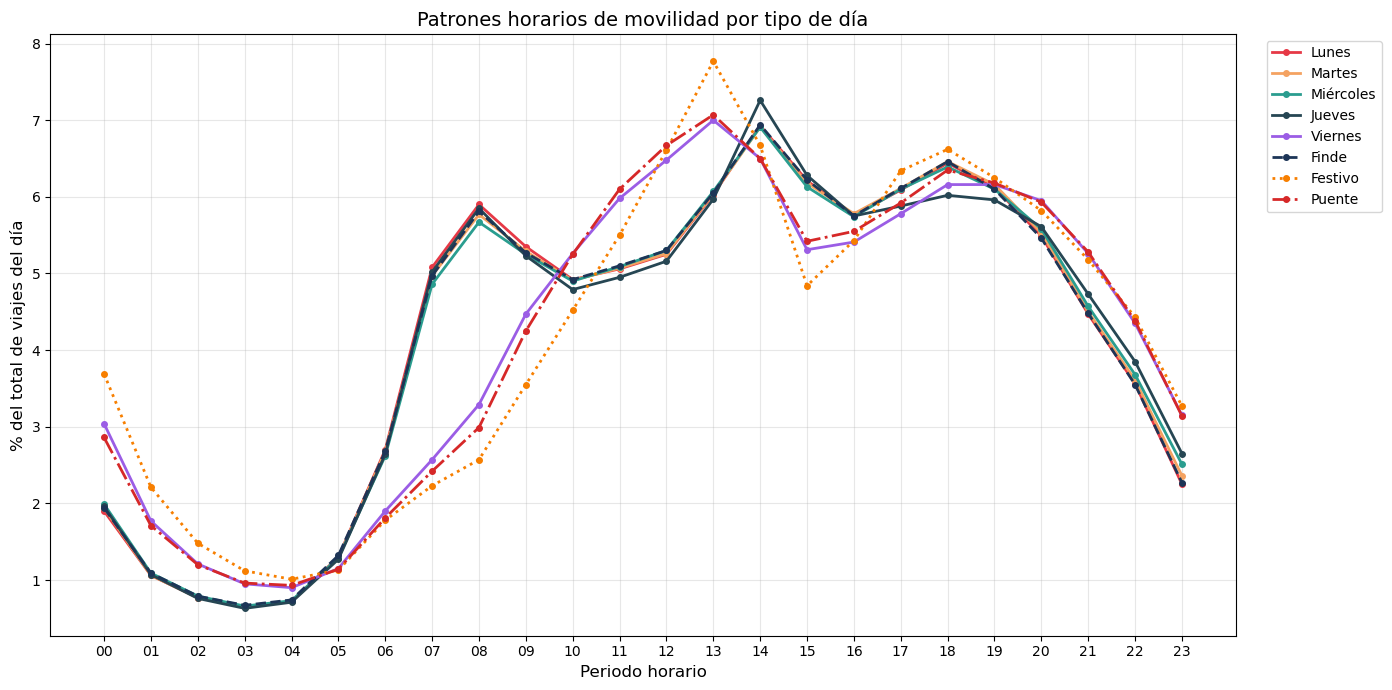

In [22]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(14, 7))

colores = {
    'Lunes': '#E63946',
    'Martes': '#F4A261', 
    'Miércoles': '#2A9D8F',
    'Jueves': '#264653',
    'Viernes': '#9B5DE5',
    'finde': '#1D3557',
    'festivo': '#F77F00',
    'puente': '#D62828'
}

estilos = {
    'Lunes': '-',
    'Martes': '-', 
    'Miércoles': '-',
    'Jueves': '-',
    'Viernes': '-',
    'finde': '--',
    'festivo': ':',
    'puente': '-.'
}

orden_categorias = ['Lunes', 'Martes', 'Miércoles', 'Jueves', 'Viernes', 'finde', 'festivo', 'puente']

for cat in orden_categorias:
    datos = df_patrones[df_patrones['categoria'] == cat]
    if len(datos) > 0:
        ax.plot(datos['hour_period'], datos['pct_del_dia'], 
                marker='o', 
                label=cat.capitalize() if cat in ['finde', 'festivo', 'puente'] else cat, 
                linewidth=2, 
                color=colores[cat],
                linestyle=estilos[cat],
                markersize=4)

ax.set_xlabel('Periodo horario', fontsize=12)
ax.set_ylabel('% del total de viajes del día', fontsize=12)
ax.set_title('Patrones horarios de movilidad por tipo de día', fontsize=14)
ax.legend(bbox_to_anchor=(1.02, 1), loc='upper left')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [12]:
# Configurar para usar menos memoria
con.execute("SET threads=2")
con.execute("SET preserve_insertion_order=false")

# Detectar outliers sin agregar trips
df_outliers_ma = SQL("""
WITH stats_por_zona AS (
    SELECT 
        origin_zone,
        destination_zone,
        AVG(trips) AS media_zona,
        STDDEV(trips) AS std_zona
    FROM viajes_clasificados
    GROUP BY origin_zone, destination_zone
)
SELECT 
    v.origin_zone,
    v.destination_zone,
    v.date,
    v.hour_period,
    v.trips,
    s.media_zona,
    s.std_zona,
    (v.trips - s.media_zona) / NULLIF(s.std_zona, 0) AS z_score,
    CASE 
        WHEN v.trips > s.media_zona + 10 * s.std_zona THEN 'alto'
        WHEN v.trips < s.media_zona - 10 * s.std_zona THEN 'bajo'
    END AS tipo_outlier
FROM viajes_clasificados v
JOIN stats_por_zona s 
    ON v.origin_zone = s.origin_zone 
    AND v.destination_zone = s.destination_zone
WHERE v.trips > s.media_zona + 10 * s.std_zona 
   OR v.trips < s.media_zona - 10 * s.std_zona
ORDER BY ABS((v.trips - s.media_zona) / NULLIF(s.std_zona, 0)) DESC
""")

print(f"Outliers detectados: {len(df_outliers_ma)}")
df_outliers_ma.head(20)

Outliers detectados: 83642


,origin_zone,destination_zone,date,hour_period,trips,media_zona,std_zona,z_score,tipo_outlier
0,47086_AM,47086_AM,20230127,11,756.658000,10.256966,16.592478,44.984300,alto
1,48082,4801307,20230125,14,118.000000,4.333048,2.605593,43.624215,alto
2,4109501,4109505,20230124,01,394.443000,8.241771,9.716335,39.747624,alto
3,4108102,4108102,20230117,22,641.040000,11.463968,15.892786,39.613950,alto
4,4108102,4108102,20230117,22,624.025000,11.463968,15.892786,38.543339,alto
5,2004502,31153_AM,20230103,10,92.875000,3.025373,2.359593,38.078444,alto
6,41021,4109108,20230114,16,99.000000,3.853754,2.572021,36.992802,alto
7,35003_AM,3501701,20230118,08,365.271000,8.032225,10.047142,35.556259,alto
8,28127,2807908,20230114,04,313.615000,7.403575,8.632034,35.473842,alto
9,4109505,4109501,20230124,04,343.548000,8.375864,9.617247,34.851151,alto


In [ ]:
# See details of a specific outlier detected

SQL("""
SELECT 
    origin_zone,
    destination_zone,
    date,
    hour_period,
    trips
FROM viajes_clasificados
WHERE origin_zone = '47086_AM' 
  AND destination_zone = '47086_AM'
  AND date = 20230127
  AND hour_period = 11
ORDER BY date, hour_period
LIMIT 50;
""")

,origin_zone,destination_zone,date,hour_period,trips
0,47086_AM,47086_AM,20230127,11,16.750
1,47086_AM,47086_AM,20230127,11,2.642
2,47086_AM,47086_AM,20230127,11,2.681
3,47086_AM,47086_AM,20230127,11,6.000
4,47086_AM,47086_AM,20230127,11,2.958
5,47086_AM,47086_AM,20230127,11,3.587
6,47086_AM,47086_AM,20230127,11,3.440
7,47086_AM,47086_AM,20230127,11,5.483
8,47086_AM,47086_AM,20230127,11,1.863
9,47086_AM,47086_AM,20230127,11,14.556


In [19]:
# Check if the outlier represents the sum of other trips of the same period

SQL("""
SELECT 
    SUM(trips) AS suma_total,
    SUM(CASE WHEN trips != 756.658 THEN trips ELSE 0 END) AS suma_sin_outlier,
    MAX(CASE WHEN trips = 756.658 THEN trips END) AS valor_outlier,
    COUNT(*) AS total_filas,
    SUM(CASE WHEN trips != 756.658 THEN trips ELSE 0 END) - 756.658 AS diferencia
FROM viajes_clasificados
WHERE origin_zone = '47086_AM' 
  AND destination_zone = '47086_AM'
  AND date = 20230127
  AND hour_period = 11
""")

,suma_total,suma_sin_outlier,valor_outlier,total_filas,diferencia
0,1413.091,656.433,756.658,50,-100.225


In [21]:
# Since the outlier does not represent the sum of other trips, we will delete them from our bronze_raw_mobility_trips table

con.execute("""
DELETE FROM bronze_raw_mobility_trips
WHERE (origin_zone, destination_zone, date, hour_period, trips) IN (
    WITH stats_por_zona AS (
        SELECT 
            origin_zone,
            destination_zone,
            AVG(trips) AS media_zona,
            STDDEV(trips) AS std_zona
        FROM bronze_raw_mobility_trips
        GROUP BY origin_zone, destination_zone
    )
    SELECT 
        v.origin_zone,
        v.destination_zone,
        v.date,
        v.hour_period,
        v.trips
    FROM bronze_raw_mobility_trips v
    JOIN stats_por_zona s 
        ON v.origin_zone = s.origin_zone 
        AND v.destination_zone = s.destination_zone
    WHERE v.trips > s.media_zona + 10 * s.std_zona 
       OR v.trips < s.media_zona - 10 * s.std_zona
)
""")

print("Outliers eliminados de bronze_raw_mobility_trips")

Outliers eliminados de bronze_raw_mobility_trips


In [23]:
# Verify that there are no invalid hour_period values

SQL("""
SELECT DISTINCT hour_period 
FROM bronze_raw_mobility_trips 
WHERE CAST(hour_period AS INT) NOT BETWEEN 0 AND 23
""")

,hour_period


In [24]:
# Verify that there are no invalid date values

SQL("""
SELECT MIN(date), MAX(date), 
       COUNT(CASE WHEN date < 20230101 OR date > 20231231 THEN 1 END) AS fechas_fuera_rango
FROM bronze_raw_mobility_trips
""")

,min(date),max(date),fechas_fuera_rango
0,20230101,20231231,0


In [ ]:
# Verify that there are no negative or null trips values

SQL("""
SELECT 
    COUNT(CASE WHEN trips < 0 THEN 1 END) AS trips_negativos,
    COUNT(CASE WHEN trips IS NULL THEN 1 END) AS trips_nulos
FROM bronze_raw_mobility_trips
""")

,trips_negativos,trips_nulos
0,0,0


: 

In [ ]:
SQL("""
SELECT 
    COUNT(DISTINCT origin_zone) AS origin_sin_match,
    COUNT(DISTINCT destination_zone) AS destination_sin_match
FROM bronze_raw_mobility_trips
WHERE origin_zone NOT IN (SELECT codigo_distrito FROM silver_secciones_censales_wgs84)
   OR destination_zone NOT IN (SELECT codigo_distrito FROM silver_secciones_censales_wgs84)
""")

,origin_sin_match,destination_sin_match
0,3857,3857


In [5]:
# Delete all trips with origin_zone or destination_zone starting with 'PT' (Portugal)

con.execute("""
DELETE FROM bronze_raw_mobility_trips
WHERE origin_zone LIKE 'PT%' OR destination_zone LIKE 'PT%'
""")

In [ ]:
# Delete all trips with origin_zone or destination_zone starting with 'FR' (France)

con.execute("""
DELETE FROM bronze_raw_mobility_trips
WHERE origin_zone LIKE 'FR%' OR destination_zone LIKE 'FR%'
""")

In [ ]:
# Delete all trips with origin_zone or destination_zone equal to 'externo'

con.execute("""
DELETE FROM bronze_raw_mobility_trips
WHERE origin_zone = 'externo' OR destination_zone = 'externo'
""")

In [ ]:
# Remove '_AM' suffix from origin_zone and destination_zone

con.execute("""
UPDATE bronze_raw_mobility_trips
SET origin_zone = REPLACE(origin_zone, '_AM', ''),
    destination_zone = REPLACE(destination_zone, '_AM', '')
WHERE origin_zone LIKE '%_AM' OR destination_zone LIKE '%_AM'
""")

In [7]:
# Remove '_AD' suffix from origin_zone and destination_zone

con.execute("""
UPDATE bronze_raw_mobility_trips
SET origin_zone = REPLACE(origin_zone, '_AD', ''),
    destination_zone = REPLACE(destination_zone, '_AD', '')
WHERE origin_zone LIKE '%_AD' OR destination_zone LIKE '%_AD'
""")

In [8]:
# Verify that all origin_zone and destination_zone values match the codes in silver_secciones_censales_wgs84

SQL("""
SELECT DISTINCT origin_zone AS zona_sin_match, 'origin' AS tipo
FROM bronze_raw_mobility_trips
WHERE origin_zone NOT IN (SELECT codigo_distrito FROM silver_secciones_censales_wgs84)
  AND origin_zone NOT IN (SELECT codigo_municipio FROM silver_secciones_censales_wgs84)
UNION
SELECT DISTINCT destination_zone, 'destination'
FROM bronze_raw_mobility_trips
WHERE destination_zone NOT IN (SELECT codigo_distrito FROM silver_secciones_censales_wgs84)
  AND destination_zone NOT IN (SELECT codigo_municipio FROM silver_secciones_censales_wgs84)
ORDER BY zona_sin_match
""")

,zona_sin_match,tipo
